In [1]:
import os
import sys
import glob
import datetime
import calendar

import numpy as np
import xarray as xr
import scipy
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cartopy.crs as ccrs
# import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
# import geocat.datafiles as gdf
# from geocat.viz import cmaps as gvcmaps
# from geocat-viz import cmaps as gvcmaps
import cmaps
from geocat.viz import util as gvutil

In [2]:
DIR_ROOT = '/glade/u/home/lgchen/lgchen_work/project/OISSH_JEDI/JEDI-SSH_Derecho/generic-marine-jedi_Derecho'

DIR_ORG_S1_OE1 = DIR_ROOT + '/cycling_ssh/ana/past_result/j1j2j3_org_scale1_obsErr1cm_default'
DIR_HP_S1_OE1 = DIR_ROOT + '/cycling_ssh_2nd/ana/past_result/j1j2j3_hp_scale1_obsErr1cm'
DIR_LP_S10_OE1 = DIR_ROOT + '/cycling_ssh_3rd/ana/past_result/j1j2j3_lp_scale10_obsErr1cm'
DIR_LP_S10_OE10 = DIR_ROOT + '/cycling_ssh_3rd/ana/past_result/j1j2j3_lp_scale10_obsErr10cm'


In [3]:
ds_org_s1_oe1 = xr.open_mfdataset(paths=DIR_ORIG_S1_OE1 + '/ana.2002*.nc', concat_dim='time', combine='nested')
ds_hp_s1_oe1 = xr.open_mfdataset(paths=DIR_HP_S1_OE1 + '/ana.2002*.nc', concat_dim='time', combine='nested')
ds_lp_s10_oe1 = xr.open_mfdataset(paths=DIR_LP_S10_OE1 + '/ana.2002*.nc', concat_dim='time', combine='nested')
ds_lp_s10_oe10 = xr.open_mfdataset(paths=DIR_LP_S10_OE10 + '/ana.2002*.nc', concat_dim='time', combine='nested')

print(ds_orig)
print(ds_high_pass)
print(ds_low_pass)

<xarray.Dataset>
Dimensions:                  (time: 365, lat: 720, lon: 1440)
Dimensions without coordinates: time, lat, lon
Data variables:
    seaSurfaceHeightAnomaly  (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
<xarray.Dataset>
Dimensions:                  (time: 365, lat: 720, lon: 1440)
Dimensions without coordinates: time, lat, lon
Data variables:
    seaSurfaceHeightAnomaly  (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
<xarray.Dataset>
Dimensions:                  (time: 365, lat: 720, lon: 1440)
Dimensions without coordinates: time, lat, lon
Data variables:
    seaSurfaceHeightAnomaly  (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>


In [4]:
# calculate the yearly average of the above ds_orig, ds_high_pass, ds_low_pass
da_ssh_mean_orig = ds_orig['seaSurfaceHeightAnomaly'].mean(dim='time', skipna=True)
da_ssh_mean_hp = ds_high_pass['seaSurfaceHeightAnomaly'].mean(dim='time', skipna=True)
da_ssh_mean_lp = ds_low_pass['seaSurfaceHeightAnomaly'].mean(dim='time', skipna=True)
print(da_ssh_mean_orig)
print(da_ssh_mean_hp)
print(da_ssh_mean_lp)

<xarray.DataArray 'seaSurfaceHeightAnomaly' (lat: 720, lon: 1440)>
dask.array<mean_agg-aggregate, shape=(720, 1440), dtype=float32, chunksize=(720, 1440), chunktype=numpy.ndarray>
Dimensions without coordinates: lat, lon
<xarray.DataArray 'seaSurfaceHeightAnomaly' (lat: 720, lon: 1440)>
dask.array<mean_agg-aggregate, shape=(720, 1440), dtype=float32, chunksize=(720, 1440), chunktype=numpy.ndarray>
Dimensions without coordinates: lat, lon
<xarray.DataArray 'seaSurfaceHeightAnomaly' (lat: 720, lon: 1440)>
dask.array<mean_agg-aggregate, shape=(720, 1440), dtype=float32, chunksize=(720, 1440), chunktype=numpy.ndarray>
Dimensions without coordinates: lat, lon


In [5]:
DIR_AVISO_ROOT = '/glade/u/home/lgchen/umcp0014/lgchen/OISSH_JEDI_DATA/aviso-sealevel'
DIR_AVISO_DAILY = DIR_AVISO_ROOT + '/quarter-deg_daily'
DIR_AVISO_MONTHLY = DIR_AVISO_ROOT + '/1993-2022_monthly'

ds_aviso_mly = xr.open_mfdataset(paths=DIR_AVISO_MONTHLY + '/quarter-deg/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1M-m_*.nc'  \
    , decode_times=False, concat_dim='time', combine='nested')
print(ds_aviso_mly)
print(ds_aviso_mly['time'])

<xarray.Dataset>
Dimensions:    (time: 360, longitude: 1440, latitude: 720)
Coordinates:
  * time       (time) float64 0.0 1.0 2.0 3.0 4.0 ... 31.0 32.0 33.0 34.0 35.0
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
Data variables:
    sla        (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/14)
    CDI:               Climate Data Interface version 1.9.2 (http://mpimet.mp...
    history:           Fri Apr 19 14:13:50 2024: cdo settaxis,1993-01-01,12:0...
    source:            Altimetry measurements
    institution:       CNES, CLS
    Conventions:       CF-1.11
    title:             DT merged all satellites Global Ocean Ocean Gridded Mo...
    ...                ...
    comment:           Monthly Mean of Sea Level Anomalies referenced to the ...
    subset:source:     ARCO data downloaded from the Marine Data Store usin

In [3]:
# initially 2014
ds_aviso_dly = xr.open_dataset(filename_or_obj=DIR_AVISO_DAILY + '/l4-duacs-0.25deg_P1D_2010b.nc'  \
    , mask_and_scale=True, decode_times=True, drop_variables=['longitude_bnds', 'latitude_bnds', 'ugosa', 'err_ugosa'  \
    , 'vgosa', 'err_vgosa', 'adt', 'ugos', 'vgos', 'flag_ice', 'tpa_correction'])
print(ds_aviso_dly)
print(ds_aviso_dly['time'])

<xarray.Dataset>
Dimensions:    (time: 365, longitude: 1440, latitude: 720)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2010-12-31
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
Data variables:
    crs        int32 ...
    sla        (time, latitude, longitude) float32 ...
    err_sla    (time, latitude, longitude) float32 ...
Attributes: (12/47)
    CDI:                             Climate Data Interface version 1.9.2 (ht...
    Conventions:                     CF-1.6
    history:                         Sun May 28 17:18:22 2023: cdo -b f32 -f ...
    source:                          Altimetry measurements
    institution:                     CLS, CNES
    _NCProperties:                   version=2,netcdf=4.7.4,hdf5=1.10.6
    ...                              ...
    time_coverage_duration:          P1D
    time_coverage_end:               2010-01

In [ ]:
# temporary to check result of 2010-01-10
ds_orig_10times = xr.open_dataset(filename_or_obj=DIR_ROOT + '/cycling_ssh/ana/ana.2010011012.nc'  \
    , mask_and_scale=True, decode_times=True)
print(ds_orig_10times)


# set up for plot
fig = plt.figure(figsize=(12, 12))
fig.suptitle('SSH diff (JEDI-AVISO) for 2010-01-10', fontsize=18, y=0.70)  # y initially 0.95
# grid = fig.add_gridspec(nrows=3, ncols=2, height_ratios=[0.55, 0.45], hspace=-0.25, wspace=0.125)
grid = fig.add_gridspec(nrows=1, ncols=1, wspace=0.15, hspace=-0.4) # wspace=-0.05

proj = ccrs.PlateCarree()
cmap = cmaps.BlueYellowRed

# levels = np.arange(-0.45, 0.451, 0.1)
# levels = np.arange(-0.27, 0.271, 0.06)
levels_diff = np.arange(-0.14, 0.141, 0.04)
# levels_diff = np.arange(0, 0.22, 0.03)

title = ['orig-aviso']

ax = []  # 1st: just setup the axes
for i in range(1):
    ax.append(fig.add_subplot(grid[i], projection=proj))
    ax[i].set_global()
    ax[i].coastlines(linewidth=0.5)
    ax[i].set_xlabel('', fontsize=10)
    ax[i].set_ylabel('', fontsize=10)
    ax[i].set_title(label=title[i], loc='center', fontsize=10, y=1.0, pad=6.0)
    ax[i].set_title(label='SLA diff', loc='left', fontsize=10, y=1.0, pad=6.0)
    ax[i].set_title(label='m', loc='right', fontsize=10, y=1.0, pad=6.0)

  # even if the lon is 0~360 and the lat 90~-90, you should still set as follows.
    gvutil.set_axes_limits_and_ticks(ax=ax[i], xlim=(-180, 180), ylim=(-90, 90)  \
        , xticks=np.linspace(-120, 120, 5), yticks=np.linspace(-60, 60, 5))
    gvutil.add_lat_lon_ticklabels(ax[i])
    ax[i].xaxis.set_major_formatter(LongitudeFormatter(degree_symbol=''))
    ax[i].yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))

# 2nd: plot data
ct = [0]*1
#ct[0] = ds_aviso_dly['sla'][45, :, :].plot.contourf(ax=ax[0], vmin=-1, vmax=1  \
#    , levels=10, cmap=cmap, add_colorbar=True, transform=proj, add_labels=False)
# vmin=0, vmax=0.5
ct[0] = ax[0].contourf(ds_aviso_dly['longitude'], ds_aviso_dly['latitude'], ds_orig_10times['seaSurfaceHeightAnomaly'].data[0, :, :]
    - ds_aviso_dly['sla'].data[9, :, :], levels=levels_diff, cmap=cmap, extend='both')

#fig.colorbar(ct[2], ax=ax[2], extend='both')
#fig.colorbar(ct[1], ax=ax[1], extend='both')
#fig.colorbar(ct[3], ax=ax[3], extend='both')

fig.colorbar(ct[0], ax=[ax[0]], orientation='horizontal', extend='both', shrink=0.5, pad=0.05)
#fig.colorbar(ct[5], ax=[ax[1], ax[3], ax[5]], orientation='horizontal', extend='both', shrink=0.8, pad=0.05)
#cbar_01 = plt.colorbar(mappable=ct[4], cax=ax[4], orientation='horizontal', shrink=0.5, pad=0.05  \
#    , extend='both', extendrect=False, extendfrac='auto', drawedges=False)
#cbar_01.ax.tick_params(labelsize=8)

#cbar_02 = plt.colorbar(mappable=ct[5], cax=ax[5], orientation='horizontal', shrink=0.5, pad=0.05  \
#    , extend='both', extendrect=False, extendfrac='auto', drawedges=False)
#cbar_02.ax.tick_params(labelsize=8)

# plt.show()
plt.savefig('./ssh_diff_orig_aviso_01.png')

/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar', 'add_labels'
  result = super().contourf(*args, **kwargs)


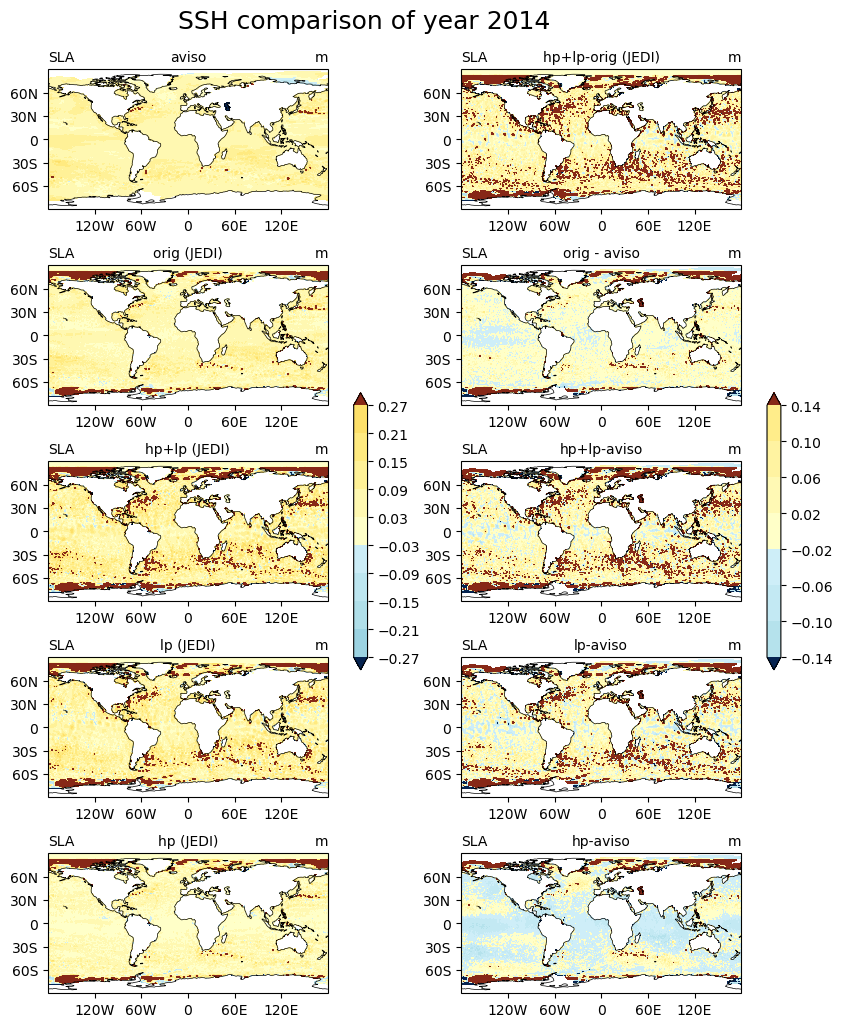

In [11]:
# set up for plot
fig = plt.figure(figsize=(12, 12))
fig.suptitle('SSH comparison of year 2014', fontsize=18, y=0.93)  # y initially 0.95
# grid = fig.add_gridspec(nrows=3, ncols=2, height_ratios=[0.55, 0.45], hspace=-0.25, wspace=0.125)
grid = fig.add_gridspec(nrows=5, ncols=2, wspace=-0.20, hspace=0.4)  # wspace=-0.05

proj = ccrs.PlateCarree()
cmap = cmaps.BlueYellowRed

# levels = np.arange(-0.45, 0.451, 0.1)
levels = np.arange(-0.27, 0.271, 0.06)
levels_diff = np.arange(-0.14, 0.141, 0.04)

title = ['aviso', 'hp+lp-orig (JEDI)', 'orig (JEDI)', 'orig - aviso', 'hp+lp (JEDI)', 'hp+lp-aviso', 'lp (JEDI)', 'lp-aviso', 'hp (JEDI)', 'hp-aviso']

ax = []  # 1st: just setup the axes
for i in range(10):
    ax.append(fig.add_subplot(grid[i], projection=proj))
    ax[i].set_global()
    ax[i].coastlines(linewidth=0.5)
    ax[i].set_xlabel('', fontsize=10)
    ax[i].set_ylabel('', fontsize=10)
    ax[i].set_title(label=title[i], loc='center', fontsize=10, y=1.0, pad=6.0)
    ax[i].set_title(label='SLA', loc='left', fontsize=10, y=1.0, pad=6.0)
    ax[i].set_title(label='m', loc='right', fontsize=10, y=1.0, pad=6.0)

  # even if the lon is 0~360 and the lat 90~-90, you should still set as follows.
    gvutil.set_axes_limits_and_ticks(ax=ax[i], xlim=(-180, 180), ylim=(-90, 90)  \
        , xticks=np.linspace(-120, 120, 5), yticks=np.linspace(-60, 60, 5))
    gvutil.add_lat_lon_ticklabels(ax[i])
    ax[i].xaxis.set_major_formatter(LongitudeFormatter(degree_symbol=''))
    ax[i].yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))

# 2nd: plot data
ct = [0]*10
#ct[0] = ds_aviso_dly['sla'][45, :, :].plot.contourf(ax=ax[0], vmin=-1, vmax=1  \
#    , levels=10, cmap=cmap, add_colorbar=True, transform=proj, add_labels=False)
ct[0] = ax[0].contourf(ds_aviso_dly['longitude'], ds_aviso_dly['latitude'], da_ssh_mean_aviso.data  \
    , vmin=-1, vmax=1, levels=levels, cmap=cmap, extend='both', add_colorbar=True, transform=proj, add_labels=False)
ct[2] = ax[2].contourf(ds_aviso_dly['longitude'], ds_aviso_dly['latitude'], da_ssh_mean_orig.data
    , vmin=-1, vmax=1, levels=levels, cmap=cmap, extend='both')
ct[4] = ax[4].contourf(ds_aviso_dly['longitude'], ds_aviso_dly['latitude'], da_ssh_mean_lp.data
    + da_ssh_mean_hp.data, vmin=-1, vmax=1, levels=levels, cmap=cmap, extend='both')
ct[6] = ax[6].contourf(ds_aviso_dly['longitude'], ds_aviso_dly['latitude'], da_ssh_mean_lp.data
    , vmin=-1, vmax=1, levels=levels, cmap=cmap, extend='both')
ct[8] = ax[8].contourf(ds_aviso_dly['longitude'], ds_aviso_dly['latitude'], da_ssh_mean_hp.data
    , vmin=-1, vmax=1, levels=levels, cmap=cmap, extend='both')

ct[1] = ax[1].contourf(ds_aviso_dly['longitude'], ds_aviso_dly['latitude'], da_ssh_mean_lp.data
    + da_ssh_mean_hp.data - da_ssh_mean_orig.data  \
    , vmin=-0.8, vmax=0.8, levels=levels_diff, cmap=cmap, extend='both')
ct[3] = ax[3].contourf(ds_aviso_dly['longitude'], ds_aviso_dly['latitude'], da_ssh_mean_orig.data
    - da_ssh_mean_aviso.data, vmin=-0.8, vmax=0.8, levels=levels_diff, cmap=cmap, extend='both')
ct[5] = ax[5].contourf(ds_aviso_dly['longitude'], ds_aviso_dly['latitude'], da_ssh_mean_lp.data
    + da_ssh_mean_hp.data - da_ssh_mean_aviso.data  \
    , vmin=-0.8, vmax=0.8, levels=levels_diff, cmap=cmap, extend='both')
ct[7] = ax[7].contourf(ds_aviso_dly['longitude'], ds_aviso_dly['latitude'], da_ssh_mean_lp.data - da_ssh_mean_aviso.data  \
    , vmin=-0.8, vmax=0.8, levels=levels_diff, cmap=cmap, extend='both')
ct[9] = ax[9].contourf(ds_aviso_dly['longitude'], ds_aviso_dly['latitude'], da_ssh_mean_hp.data - da_ssh_mean_aviso.data  \
    , vmin=-0.8, vmax=0.8, levels=levels_diff, cmap=cmap, extend='both')

#fig.colorbar(ct[2], ax=ax[2], extend='both')
#fig.colorbar(ct[1], ax=ax[1], extend='both')
#fig.colorbar(ct[3], ax=ax[3], extend='both')

fig.colorbar(ct[8], ax=[ax[0], ax[2], ax[4], ax[6], ax[8]], orientation='vertical', extend='both', shrink=0.3, pad=0.05) # shrink=0.8
fig.colorbar(ct[9], ax=[ax[1], ax[3], ax[5], ax[7], ax[9]], orientation='vertical', extend='both', shrink=0.3, pad=0.05)
#cbar_01 = plt.colorbar(mappable=ct[4], cax=ax[4], orientation='horizontal', shrink=0.5, pad=0.05  \
#    , extend='both', extendrect=False, extendfrac='auto', drawedges=False)
#cbar_01.ax.tick_params(labelsize=8)

#cbar_02 = plt.colorbar(mappable=ct[5], cax=ax[5], orientation='horizontal', shrink=0.5, pad=0.05  \
#    , extend='both', extendrect=False, extendfrac='auto', drawedges=False)
#cbar_02.ax.tick_params(labelsize=8)

# plt.show()
plt.savefig('./ssh_comparison_11.png')

In [7]:
# calculate the yearly average of the above ds_aviso_dly
da_ssh_mean_aviso = ds_aviso_dly['sla'].mean(dim='time', skipna=True)
print(da_ssh_mean_aviso)

<xarray.DataArray 'sla' (latitude: 720, longitude: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88


In [11]:
np_ssh_diff_std_orig_aviso = (ds_orig['seaSurfaceHeightAnomaly'].data - ds_aviso_dly['sla'].data).std(axis=0)
np_ssh_diff_std_lp_hp_aviso = (ds_low_pass['seaSurfaceHeightAnomaly'].data + ds_high_pass['seaSurfaceHeightAnomaly'].data 
                               - ds_aviso_dly['sla'].data).std(axis=0)
np_ssh_diff_std_lp_aviso = (ds_low_pass['seaSurfaceHeightAnomaly'].data - ds_aviso_dly['sla'].data).std(axis=0)
np_ssh_diff_std_hp_aviso = (ds_high_pass['seaSurfaceHeightAnomaly'].data - ds_aviso_dly['sla'].data).std(axis=0)
print(np_ssh_diff_std_lp_hp_aviso)


dask.array<_sqrt, shape=(720, 1440), dtype=float32, chunksize=(720, 1440), chunktype=numpy.ndarray>


/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar', 'add_labels'
  result = super().contourf(*args, **kwargs)


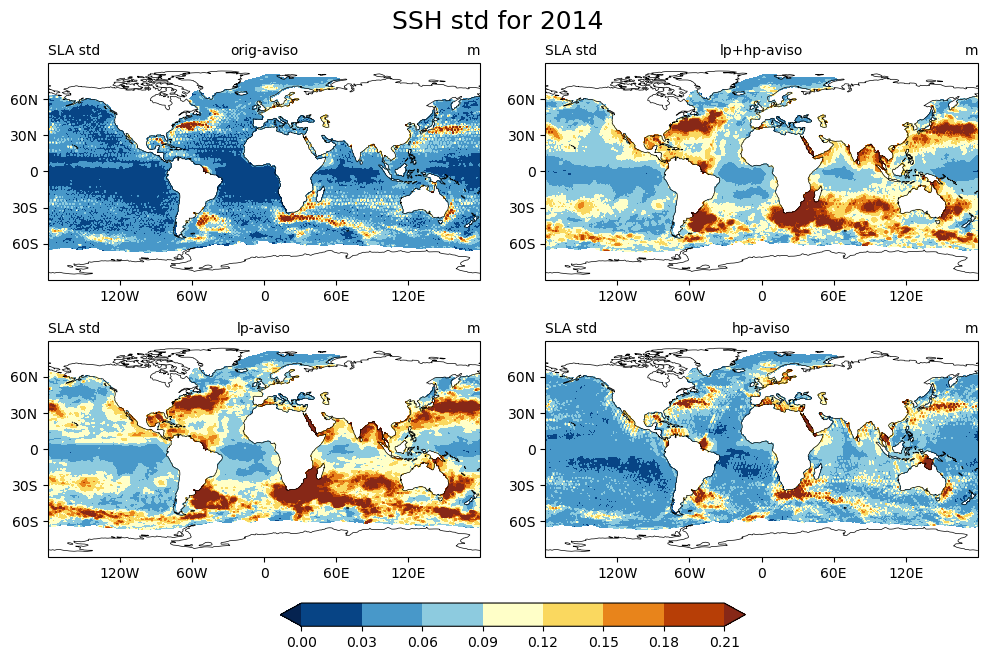

In [20]:
# set up for plot
fig = plt.figure(figsize=(12, 12))
fig.suptitle('SSH std for 2014', fontsize=18, y=0.72)  # y initially 0.95
# grid = fig.add_gridspec(nrows=3, ncols=2, height_ratios=[0.55, 0.45], hspace=-0.25, wspace=0.125)
grid = fig.add_gridspec(nrows=2, ncols=2, wspace=0.15, hspace=-0.4) # wspace=-0.05

proj = ccrs.PlateCarree()
cmap = cmaps.BlueYellowRed

# levels = np.arange(-0.45, 0.451, 0.1)
# levels = np.arange(-0.27, 0.271, 0.06)
# levels_diff = np.arange(-0.14, 0.141, 0.04)
levels_diff = np.arange(0, 0.22, 0.03)

title = ['orig-aviso', 'lp+hp-aviso', 'lp-aviso', 'hp-aviso']

ax = []  # 1st: just setup the axes
for i in range(4):
    ax.append(fig.add_subplot(grid[i], projection=proj))
    ax[i].set_global()
    ax[i].coastlines(linewidth=0.5)
    ax[i].set_xlabel('', fontsize=10)
    ax[i].set_ylabel('', fontsize=10)
    ax[i].set_title(label=title[i], loc='center', fontsize=10, y=1.0, pad=6.0)
    ax[i].set_title(label='SLA std', loc='left', fontsize=10, y=1.0, pad=6.0)
    ax[i].set_title(label='m', loc='right', fontsize=10, y=1.0, pad=6.0)

  # even if the lon is 0~360 and the lat 90~-90, you should still set as follows.
    gvutil.set_axes_limits_and_ticks(ax=ax[i], xlim=(-180, 180), ylim=(-90, 90)  \
        , xticks=np.linspace(-120, 120, 5), yticks=np.linspace(-60, 60, 5))
    gvutil.add_lat_lon_ticklabels(ax[i])
    ax[i].xaxis.set_major_formatter(LongitudeFormatter(degree_symbol=''))
    ax[i].yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))

# 2nd: plot data
ct = [0]*4
#ct[0] = ds_aviso_dly['sla'][45, :, :].plot.contourf(ax=ax[0], vmin=-1, vmax=1  \
#    , levels=10, cmap=cmap, add_colorbar=True, transform=proj, add_labels=False)
# vmin=0, vmax=0.5
ct[0] = ax[0].contourf(ds_aviso_dly['longitude'], ds_aviso_dly['latitude'], np_ssh_diff_std_orig_aviso  \
    , levels=levels_diff, cmap=cmap, extend='both', add_colorbar=True, transform=proj, add_labels=False)
ct[1] = ax[1].contourf(ds_aviso_dly['longitude'], ds_aviso_dly['latitude'], np_ssh_diff_std_lp_hp_aviso
    , levels=levels_diff, cmap=cmap, extend='both')
ct[2] = ax[2].contourf(ds_aviso_dly['longitude'], ds_aviso_dly['latitude'], np_ssh_diff_std_lp_aviso
                       , levels=levels_diff, cmap=cmap, extend='both')
ct[3] = ax[3].contourf(ds_aviso_dly['longitude'], ds_aviso_dly['latitude'], np_ssh_diff_std_hp_aviso
                       , levels=levels_diff, cmap=cmap, extend='both')

#fig.colorbar(ct[2], ax=ax[2], extend='both')
#fig.colorbar(ct[1], ax=ax[1], extend='both')
#fig.colorbar(ct[3], ax=ax[3], extend='both')

fig.colorbar(ct[3], ax=[ax[0], ax[1], ax[2], ax[3]], orientation='horizontal', extend='both', shrink=0.5, pad=0.05)
#fig.colorbar(ct[5], ax=[ax[1], ax[3], ax[5]], orientation='horizontal', extend='both', shrink=0.8, pad=0.05)
#cbar_01 = plt.colorbar(mappable=ct[4], cax=ax[4], orientation='horizontal', shrink=0.5, pad=0.05  \
#    , extend='both', extendrect=False, extendfrac='auto', drawedges=False)
#cbar_01.ax.tick_params(labelsize=8)

#cbar_02 = plt.colorbar(mappable=ct[5], cax=ax[5], orientation='horizontal', shrink=0.5, pad=0.05  \
#    , extend='both', extendrect=False, extendfrac='auto', drawedges=False)
#cbar_02.ax.tick_params(labelsize=8)

# plt.show()
plt.savefig('./ssh_std_07.png')

/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar', 'add_labels'
  result = super().contourf(*args, **kwargs)


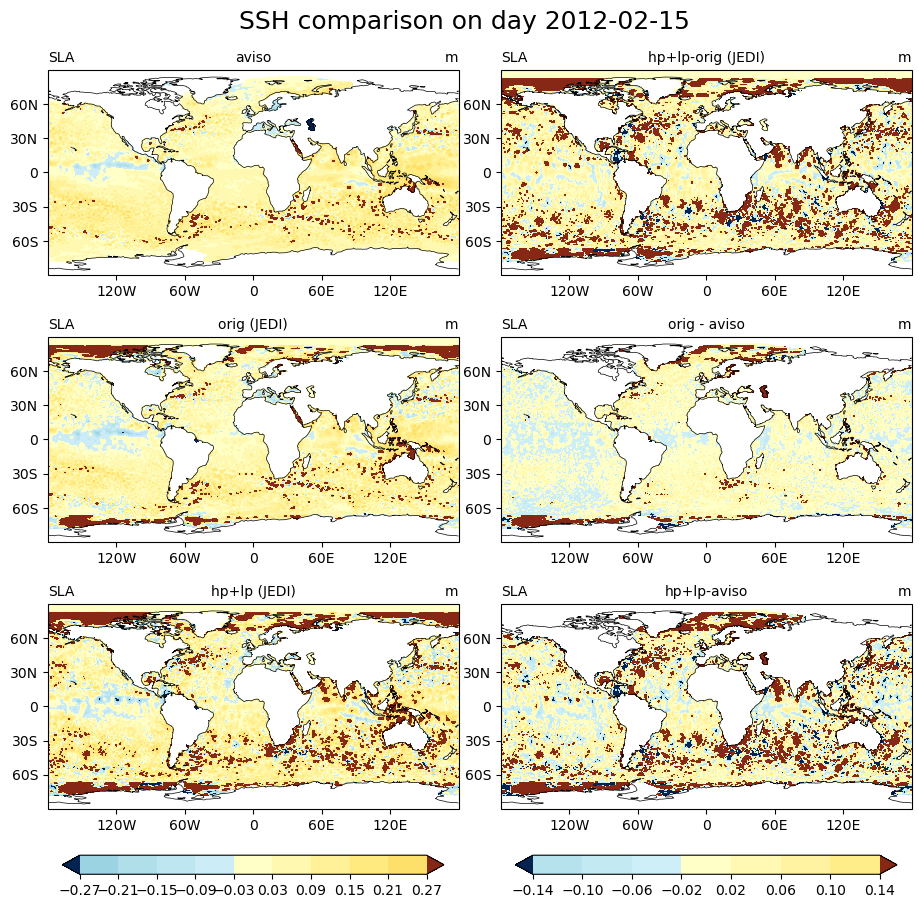

In [34]:
# set up for plot
fig = plt.figure(figsize=(12, 12))
fig.suptitle('SSH comparison on day 2012-02-15', fontsize=18, y=0.93)  # y initially 0.95
# grid = fig.add_gridspec(nrows=3, ncols=2, height_ratios=[0.55, 0.45], hspace=-0.25, wspace=0.125)
grid = fig.add_gridspec(nrows=3, ncols=2, wspace=-0.05, hspace=0.3)

proj = ccrs.PlateCarree()
cmap = cmaps.BlueYellowRed

# levels = np.arange(-0.45, 0.451, 0.1)
levels = np.arange(-0.27, 0.271, 0.06)
levels_diff = np.arange(-0.14, 0.141, 0.04)

title = ['aviso', 'hp+lp-orig (JEDI)', 'orig (JEDI)', 'orig - aviso', 'hp+lp (JEDI)', 'hp+lp-aviso']

ax = []  # 1st: just setup the axes
for i in range(6):
    ax.append(fig.add_subplot(grid[i], projection=proj))
    ax[i].set_global()
    ax[i].coastlines(linewidth=0.5)
    ax[i].set_xlabel('', fontsize=10)
    ax[i].set_ylabel('', fontsize=10)
    ax[i].set_title(label=title[i], loc='center', fontsize=10, y=1.0, pad=6.0)
    ax[i].set_title(label='SLA', loc='left', fontsize=10, y=1.0, pad=6.0)
    ax[i].set_title(label='m', loc='right', fontsize=10, y=1.0, pad=6.0)

  # even if the lon is 0~360 and the lat 90~-90, you should still set as follows.
    gvutil.set_axes_limits_and_ticks(ax=ax[i], xlim=(-180, 180), ylim=(-90, 90)  \
        , xticks=np.linspace(-120, 120, 5), yticks=np.linspace(-60, 60, 5))
    gvutil.add_lat_lon_ticklabels(ax[i])
    ax[i].xaxis.set_major_formatter(LongitudeFormatter(degree_symbol=''))
    ax[i].yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))

# 2nd: plot data
ct = [0]*6
#ct[0] = ds_aviso_dly['sla'][45, :, :].plot.contourf(ax=ax[0], vmin=-1, vmax=1  \
#    , levels=10, cmap=cmap, add_colorbar=True, transform=proj, add_labels=False)
ct[0] = ax[0].contourf(ds_aviso_dly['longitude'], ds_aviso_dly['latitude'], ds_aviso_dly['sla'].data[45, :, :], vmin=-1, vmax=1  \
    , levels=levels, cmap=cmap, extend='both', add_colorbar=True, transform=proj, add_labels=False)
ct[2] = ax[2].contourf(ds_aviso_dly['longitude'], ds_aviso_dly['latitude'], ds_orig['seaSurfaceHeightAnomaly'].data[45, :, :]
    , vmin=-1, vmax=1, levels=levels, cmap=cmap, extend='both')
ct[4] = ax[4].contourf(ds_aviso_dly['longitude'], ds_aviso_dly['latitude'], ds_high_pass['seaSurfaceHeightAnomaly'].data[45, :, :]
    + ds_low_pass['seaSurfaceHeightAnomaly'].data[45, :, :], vmin=-1, vmax=1, levels=levels, cmap=cmap, extend='both')

ct[1] = ax[1].contourf(ds_aviso_dly['longitude'], ds_aviso_dly['latitude'], ds_high_pass['seaSurfaceHeightAnomaly'].data[45, :, :]
    + ds_low_pass['seaSurfaceHeightAnomaly'].data[45, :, :] - ds_orig['seaSurfaceHeightAnomaly'].data[45, :, :]  \
    , vmin=-0.8, vmax=0.8, levels=levels_diff, cmap=cmap, extend='both')
ct[3] = ax[3].contourf(ds_aviso_dly['longitude'], ds_aviso_dly['latitude'], ds_orig['seaSurfaceHeightAnomaly'].data[45, :, :]
    - ds_aviso_dly['sla'].data[45, :, :], vmin=-0.8, vmax=0.8, levels=levels_diff, cmap=cmap, extend='both')
ct[5] = ax[5].contourf(ds_aviso_dly['longitude'], ds_aviso_dly['latitude'], ds_high_pass['seaSurfaceHeightAnomaly'].data[45, :, :]
    + ds_low_pass['seaSurfaceHeightAnomaly'].data[45, :, :] - ds_aviso_dly['sla'].data[45, :, :]  \
    , vmin=-0.8, vmax=0.8, levels=levels_diff, cmap=cmap, extend='both')

#fig.colorbar(ct[2], ax=ax[2], extend='both')
#fig.colorbar(ct[1], ax=ax[1], extend='both')
#fig.colorbar(ct[3], ax=ax[3], extend='both')

fig.colorbar(ct[4], ax=[ax[0], ax[2], ax[4]], orientation='horizontal', extend='both', shrink=0.8, pad=0.05)
fig.colorbar(ct[5], ax=[ax[1], ax[3], ax[5]], orientation='horizontal', extend='both', shrink=0.8, pad=0.05)
#cbar_01 = plt.colorbar(mappable=ct[4], cax=ax[4], orientation='horizontal', shrink=0.5, pad=0.05  \
#    , extend='both', extendrect=False, extendfrac='auto', drawedges=False)
#cbar_01.ax.tick_params(labelsize=8)

#cbar_02 = plt.colorbar(mappable=ct[5], cax=ax[5], orientation='horizontal', shrink=0.5, pad=0.05  \
#    , extend='both', extendrect=False, extendfrac='auto', drawedges=False)
#cbar_02.ax.tick_params(labelsize=8)

# plt.show()
plt.savefig('./ssh_comparison_09.png')